# Imports and preprocessing function defs




In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install ml_things
from ml_things import plot_confusion_matrix
from sklearn.metrics import classification_report, precision_recall_fscore_support
from statistics import mean


nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

# preprocessing flags
REMOVE_OUTSIDE_BOS_EOS = True
LOWERCASE_ALL_TEXT = True
REMOVE_PUNCTUATION = True
STEM = True
REMOVE_STOPWORDS = True

def extract_propaganda_span(sentence):
  """
  Extracts a propaganda span from between <BOS> and <EOS> tokens for one sentence.
  """
  #Find positions of <BOS> and <EOS>
  start_index = sentence.find('<BOS>') + len('<BOS> ') if '<BOS>' in sentence else 0
  end_index = sentence.find(' <EOS>') if '<EOS>' in sentence else len(sentence)

  span = sentence[start_index:end_index] # Extract words between <BOS> and <EOS>

  return span

def preprocess(sentence):
  """
  Performs all preprocessing steps for one sentence, including span isolation
  """
    # Remove <BOS> and <EOS>
    if REMOVE_OUTSIDE_BOS_EOS:
        sentence = extract_propaganda_span(sentence)
        sentence = extract_propaganda_span(sentence)

    # Lowercase all text
    if LOWERCASE_ALL_TEXT:
        sentence = sentence.lower()

    # Tokenize Text
    words = word_tokenize(sentence)

    # Remove Stopwords
    if REMOVE_STOPWORDS:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]

    # Remove Punctuation
    if REMOVE_PUNCTUATION:
        words = [word for word in words if word.isalnum()]

    # Stem and Lemmatise text
    if STEM:
        ps = PorterStemmer()
        lemmatizer = WordNetLemmatizer()
        words = [ps.stem(word) for word in words]

    return words

def preprocess_df(df):
  """
  Applies preprocessing to all rows in a dataframe
  """
  df['preprocessed'] = df['tagged_in_context'].apply(preprocess) # Preprocess dataset
  df.drop(columns=['tagged_in_context'], inplace=True) # Drop un-preprocessed data
  df['word-count'] = df['preprocessed'].apply(len) # Get lengths of each span

  return df

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.9 MB/s eta 0:00:00
  Created wheel for ml_things: filename=ml_things-0.0.1-py3-none-any.whl size=24393 sha256=90607969ed4ac512c8451adc1cd29aabe92075089c131f847c560bbfc7e12dea
  Stored in directory: /root/.cache/pip/wheels/2a/b9/36/3725744c1d8ebec00cd847c9461b4352ce08de9d3f20b6bdcf
Successfully built ml_things


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Data Loading

In [ ]:

# define root GDrive dir
ROOT_DIR = '/content/drive/MyDrive/ANLE_Coursework/Data/'

# read training data
df_train = pd.read_csv(ROOT_DIR + 'propaganda_train.tsv', delimiter="\t")
# read testing data
df_test = pd.read_csv(ROOT_DIR + 'propaganda_val.tsv', delimiter="\t")

# Remove Bugged TSV Rows with multiple spans
df_train = df_train.drop(index=[783, 1999, 2022, 1573])
df_test = df_test.drop(index=[293,314,420])


# Filter out non propaganda sentences
df_train = df_train[df_train['label'] != 'not_propaganda']
df_test = df_test[df_test['label'] != 'not_propaganda']

# preprocess training dataframe
df_train = preprocess_df(df_train)

# split training data into separate classes
df_train_fw = df_train[df_train['label'] == 'flag_waving'].copy()
df_train_ll = df_train[df_train['label'] == 'loaded_language'].copy()
df_train_dbt = df_train[df_train['label'] == 'doubt'].copy()
df_train_nc = df_train[df_train['label'] == 'name_calling,labeling'].copy()
df_train_atfp = df_train[df_train['label'] == 'appeal_to_fear_prejudice'].copy()
df_train_rep = df_train[df_train['label'] == 'repetition'].copy()
df_train_co = df_train[df_train['label'] == 'causal_simplification'].copy()
df_train_em = df_train[df_train['label'] == 'exaggeration,minimisation'].copy()

# put all datasets into an array
df_class_array = [df_train_fw, df_train_ll, df_train_dbt, df_train_nc, df_train_atfp, df_train_rep, df_train_co, df_train_em]


# create mapping dict for index -> technique
index_to_technique = {
    0:'flag_waving',
    1:'loaded_language',
    2:'doubt',
    3:'name_calling,labeling',
    4:'appeal_to_fear_prejudice',
    5:'repetition',
    6:'causal_simplification',
    7:'exaggeration,minimisation'
}


# preprocess test dataframe
df_test = preprocess_df(df_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Unigram Model

In [ ]:
from collections import Counter
from sklearn.metrics import confusion_matrix
from math import log


class UnigramModel():
  """
  Class for a unigram Modeller.

  Args:
      training_df: the class dataframe to use to extract n-grams from to train the n-gram model

      default_probability_value: the default probability value to assign unseen n-grams
  """

  def __init__(self, training_df, default_probability_value):

    # get preprocessed sentences
    dataset = training_df['preprocessed'].tolist()

    # init counter and word count
    unigram_counts = Counter()
    total_words = 0

    # count every unigram
    for sentence in dataset:
      unigram_counts.update(sentence)
      total_words += len(sentence)

    # store unigram model
    self.unigram_probabilities = {word: count/total_words for word, count in unigram_counts.items()}
    # store default probability value.
    self.default_probability_value = default_probability_value
    return

  def get_word_probability(self, word):
    """
    Gets the probability of a unigram, if it exists.
    Args:
        word: the word to get the probability of.
    """
    return self.unigram_probabilities.get(word, self.default_probability_value)


  def get_sentence_probability(self, preprocessed_sentence):
    """
    Gets the log probability of a provided preprocessed sentence
    Args:
        preprocessed_sentence: the preprocessed sentence to get the log probability of
    """
    # tracking variable
    total_probability = 0

    # sum the log probability of each word in the sentence.
    for word in preprocessed_sentence:
      try:
        total_probability += log(self.get_word_probability(word))
      except ValueError:
        print("") # don't do anything if error occurs, get_word_probability handles default values.

    return total_probability



def classify(preprocessed_sentence, model_array):
  """
  Classifies a given preprocessed sentence into one of eight classes.
  Args:
      preprocessed_sentence: the preprocessed sentence to classify
      model_array: An array of n-gram models for all eight classes
  """
  # tracking variable
  results = []

  # Calculate probability for each model
  for model in model_array:
    probability = model.get_sentence_probability(preprocessed_sentence)
    results.append(probability)

  # get the name of the highest probability models.
  chosen_technique = index_to_technique[results.index(max(results))]

  return chosen_technique




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Testing 8-unigram Model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


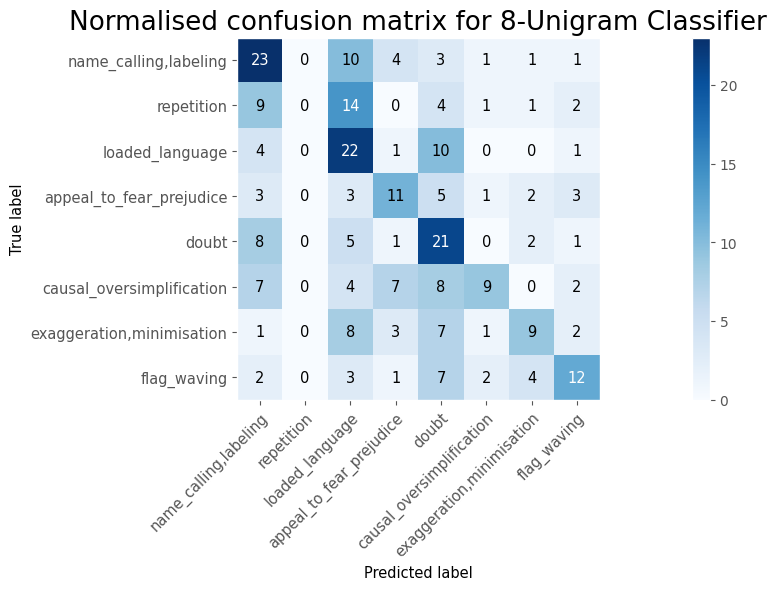

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


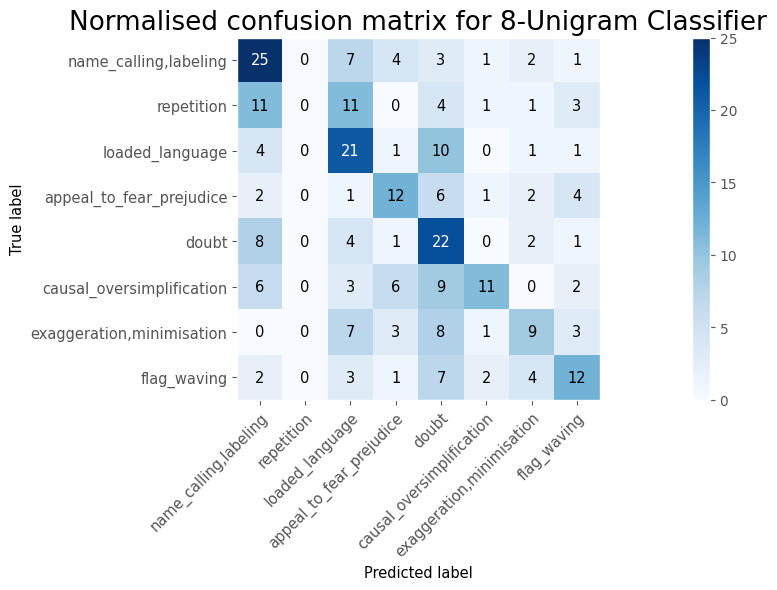

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


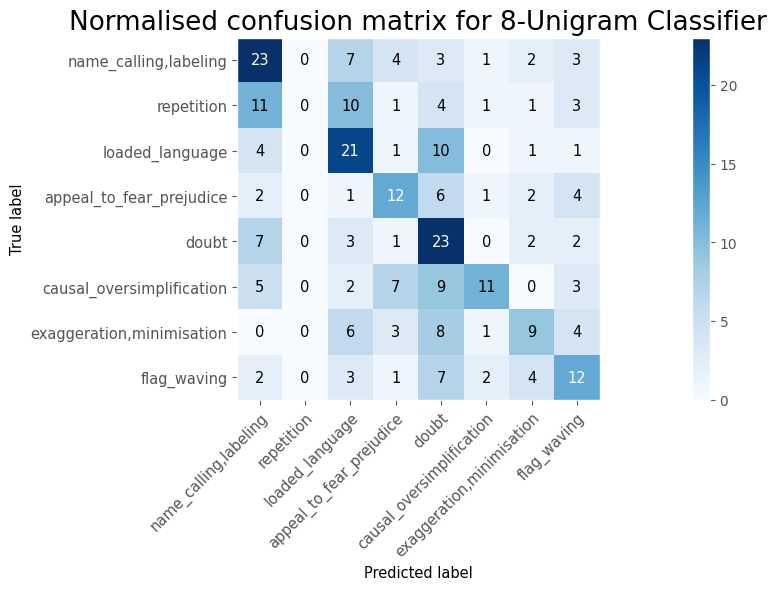

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


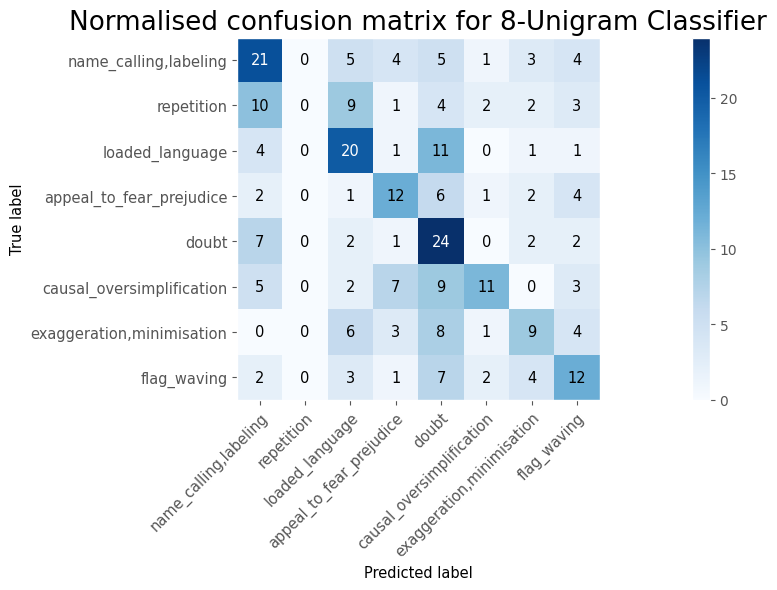

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


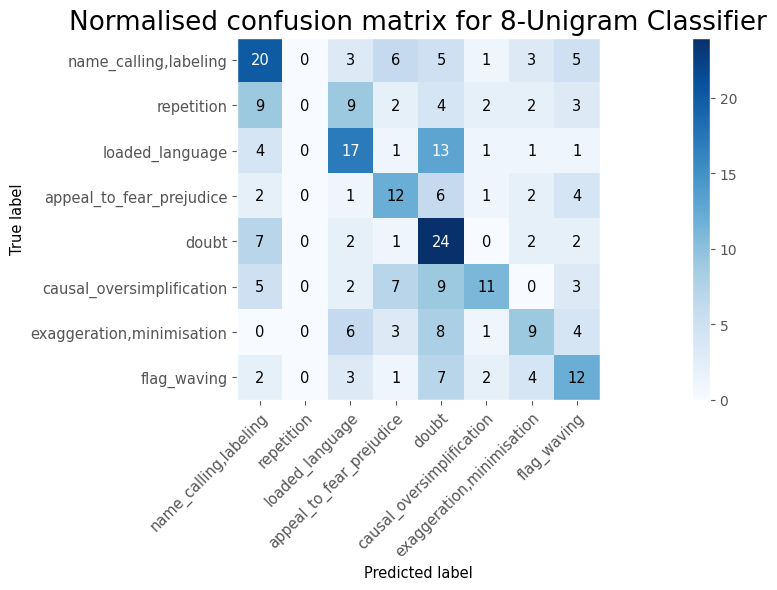

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


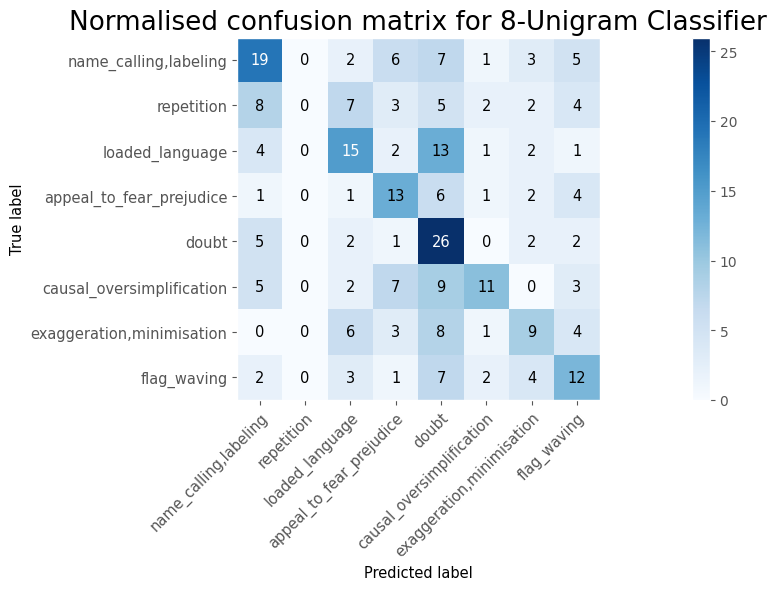

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


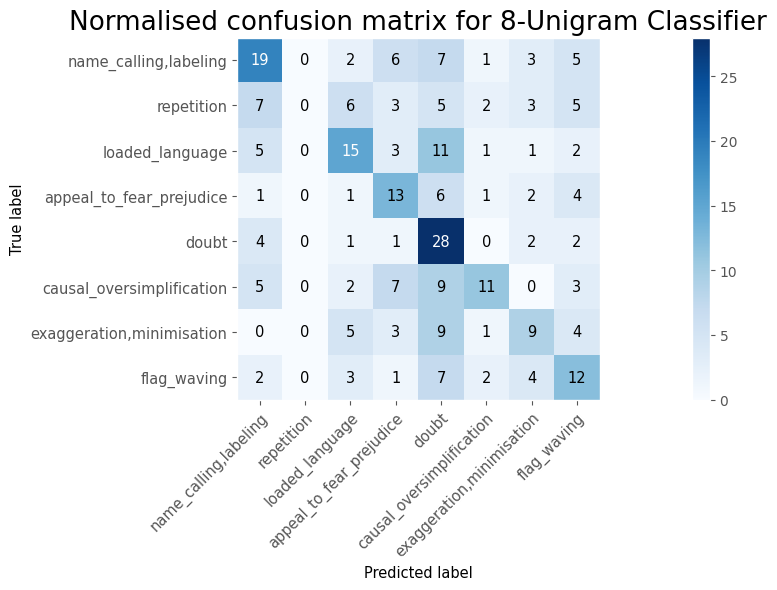

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


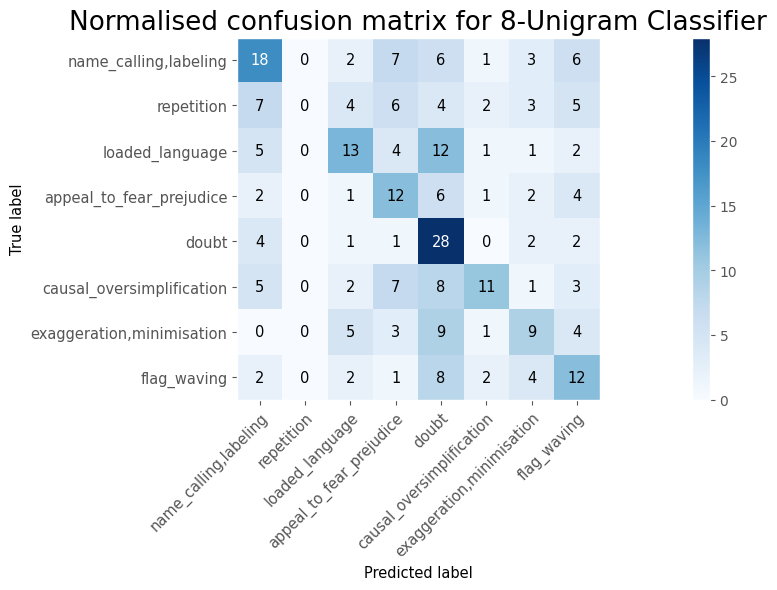

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


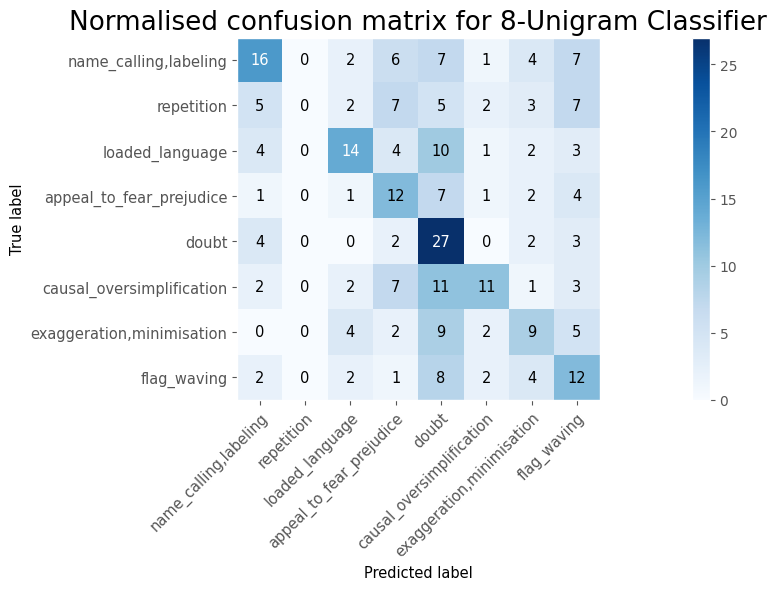

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


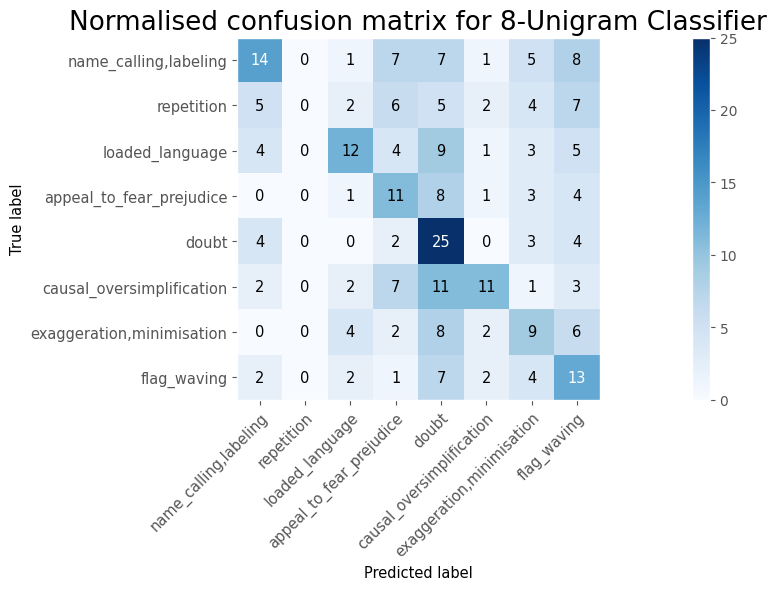

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


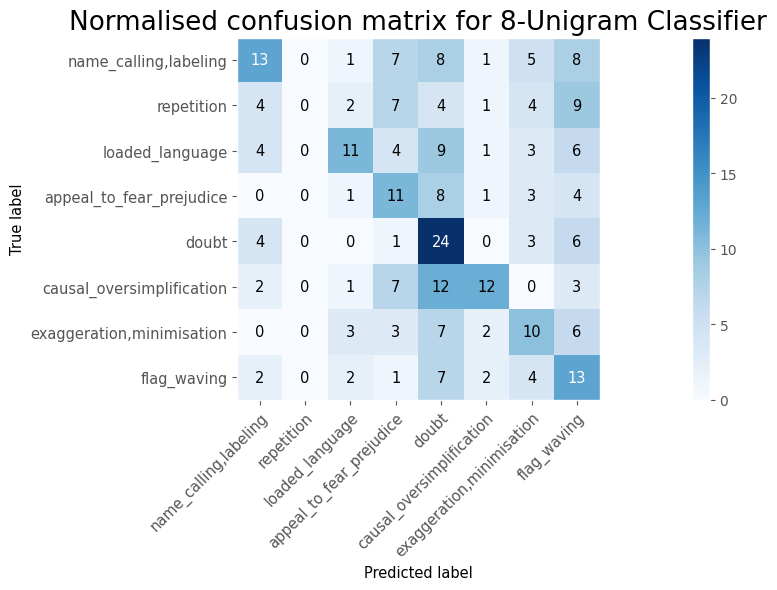

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Highest default value is: 0.0001 with F1-score: 0.368036938370047


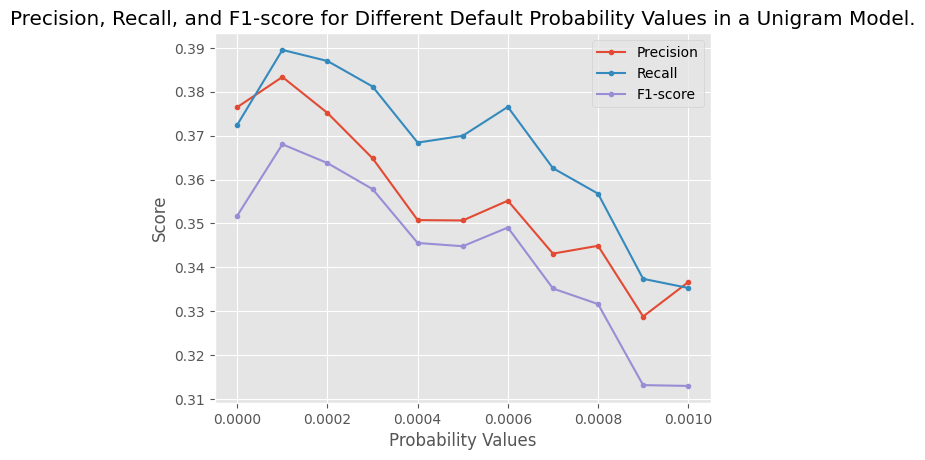

In [ ]:
# Score tracking
experiment_scores = {}

# Default values to explore
default_values = [0.0000000001, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]

# test each default value
for default_value in default_values:

  # Create an array containing all propaganda class models for `classify` function
  models_array = [UnigramModel(propaganda_class, default_value) for propaganda_class in df_class_array]

  # get true labels
  true_labels = df_test['label']
  # init prediction list
  predicted_labels = []

  # classify all test sentences
  for test_sentence in df_test['preprocessed']:
    predicted_labels.append(classify(test_sentence, models_array))

  # plot confusion matrix of true labels vs predictions
  plot_confusion_matrix(y_true=true_labels, y_pred=predicted_labels, normalize=False, title="Normalised confusion matrix for 8-Unigram Classifier", magnify=0.1)

  # get metrics
  precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels)
  precision = mean(precision)
  recall = mean(recall)
  f1_score = mean(f1_score)

  # save metrics
  experiment_scores[default_value] = [precision, recall, f1_score]


#extract precision, recall, and F1-score values
probabilities = list(experiment_scores.keys())
precision_values = [metrics[0] for metrics in experiment_scores.values()]
recall_values = [metrics[1] for metrics in experiment_scores.values()]
f1_score_values = [metrics[2] for metrics in experiment_scores.values()]

# get the best performing default value and its associated F1 score
max_index = f1_score_values.index(max(f1_score_values))
print(f"Highest default value is: {default_values[max_index]} with F1-score: {max(f1_score_values)}" )

#plot precision, recall, and F1-score
plt.plot(probabilities, precision_values, marker='.', label='Precision')
plt.plot(probabilities, recall_values, marker='.', label='Recall')
plt.plot(probabilities, f1_score_values, marker='.', label='F1-score')

#add labels and legend
plt.xlabel('Probability Values')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score for Different Default Probability Values in a Unigram Model.')
plt.legend()

# show plot
plt.grid(True)
plt.show()


unigram_f1_scores = f1_score_values

In [ ]:
# Check proportion of unseen unigrams for each classifier from test set.
models_array = [UnigramModel(propaganda_class, 123) for propaganda_class in df_class_array]
percentages = []
for i, model in enumerate(models_array):
  num_of_unseen_prop = 0

  word_count = 0
  for sentence in df_test['preprocessed']:
    for word in sentence:
      word_count += 1
      if model.get_word_probability(word) == 123:
        num_of_unseen_prop += 1

  percentage = (num_of_unseen_prop/word_count)*100
  percentages.append(percentage)

  print(f"Percentage of unseen words in {index_to_technique[i]} test set: {percentage}%")




Percentage of unseen words in flag_waving test set: 63.48522167487685%
Percentage of unseen words in loaded_language test set: 84.23645320197043%
Percentage of unseen words in doubt test set: 48.95320197044335%
Percentage of unseen words in name_calling,labeling test set: 79.37192118226602%
Percentage of unseen words in appeal_to_fear_prejudice test set: 53.94088669950739%
Percentage of unseen words in repetition test set: 82.63546798029556%
Percentage of unseen words in causal_simplification test set: 100.0%
Percentage of unseen words in exaggeration,minimisation test set: 67.98029556650246%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


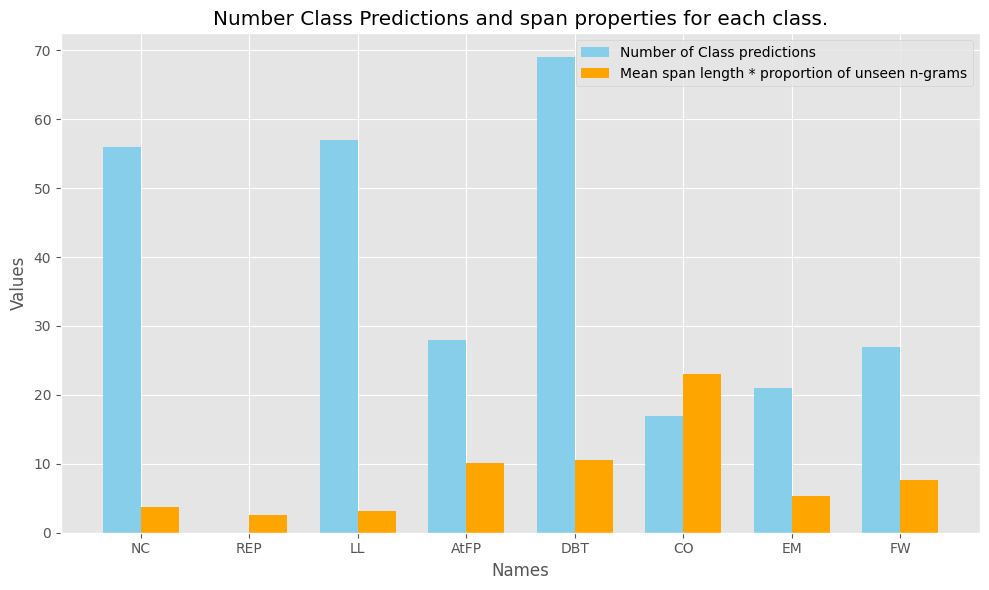

In [ ]:
# Attempt to figure out the reason for model performance through graph.
import numpy as np
import matplotlib.pyplot as plt

#values and corresponding names
number_of_class_predictions = [56, 0, 57, 28, 69, 17, 21, 27]
unseen_word_average_word_length = [4.8*0.79, 3.2*0.82, 3.7*0.84, 19*0.53, 22*0.48, 23*1, 8*0.67, 12.2*0.63]
names = ['NC', 'REP', 'LL', 'AtFP', 'DBT', 'CO', 'EM', 'FW']

r1 = np.arange(len(number_of_class_predictions))
r2 = [x + bar_width for x in r1]

# plot bars of predictions vs span length and unseen grams
plt.figure(figsize=(10, 6))
plt.bar(r1, number_of_class_predictions, color='skyblue', width=0.35, label='Number of Class predictions')
plt.bar(r2, unseen_word_average_word_length, color='orange', width=0.35, label='Mean span length * proportion of unseen n-grams')

# labels and title
plt.xlabel('Names')
plt.ylabel('Values')
plt.title('Number Class Predictions and span properties for each class.')
plt.xticks([r + bar_width/2 for r in range(len(number_of_class_predictions))], names)
plt.legend()

#show graph
plt.tight_layout()
plt.show()

# Bigram Model

In [ ]:
from nltk import bigrams

class BigramModel():
  """
  Class for a bigram Modeller.

  Arguments:
      input_df: the dataframe containing a single classes spans.
      default_probability_vlaue: the default value to use when a bigram is not found.
  """

  def __init__(self, input_df, default_probability_value):
    # store default value
    self.default_probability_value = default_probability_value

    # turn DF into list and add start and end tokens for bigram
    dataset = input_df['preprocessed'].tolist()
    dataset = [ ["<START>"] + sentence + ["<END>"] for sentence in dataset]

    # get vocab size
    all_tokens = [token for sentence in dataset for token in sentence]
    self.vocabulary_size = len(set(all_tokens))


    #create bigrams and count them
    bigrams = list(nltk.bigrams(all_tokens))
    bigram_counts = Counter(bigrams)

    #create bigram model
    self.bigram_model = {}
    for bigram, count in bigram_counts.items():
      prev_token = bigram[0]
      if prev_token not in self.bigram_model: # if word1 hasnt been seen before
          self.bigram_model[prev_token] = {}
      self.bigram_model[prev_token][bigram[1]] = count / (all_tokens.count(prev_token))
    return


  def get_bigram_probability(self, word1, word2):
    """
    gets the probability of a bigram from the model.
    args:
        word1: the first word
        word2: the second word
    """
    return self.bigram_model.get(word1, {}).get(word2,self.default_probability_value)


  def get_sentence_probability(self,preprocessed_sentence):
    """
    gets the log probability of a sentence from the model.
    """

    #split sentence into bigrams
    bigrams = list(nltk.bigrams(preprocessed_sentence))

    # tracking varibale
    total_log_probability = 0

    # find each bigram probability.
    for (word1, word2) in bigrams:
      total_log_probability += log(self.get_bigram_probability(word1, word2))
    return total_log_probability

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


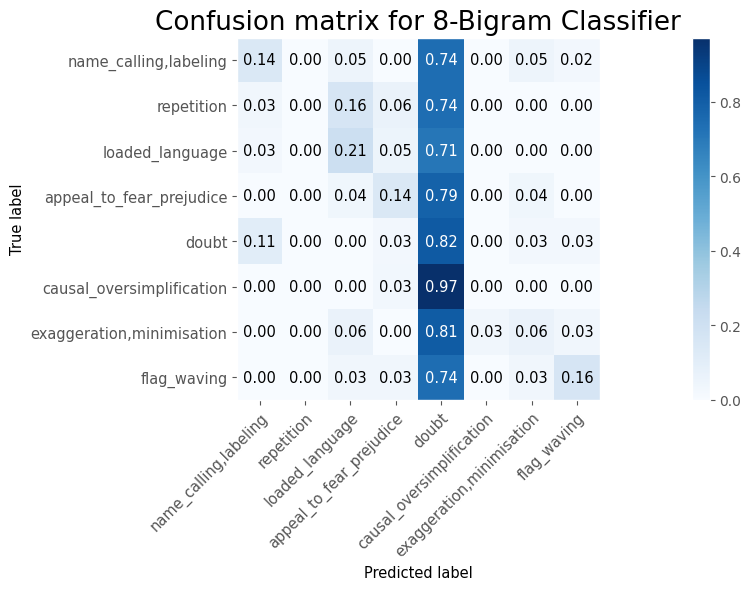

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


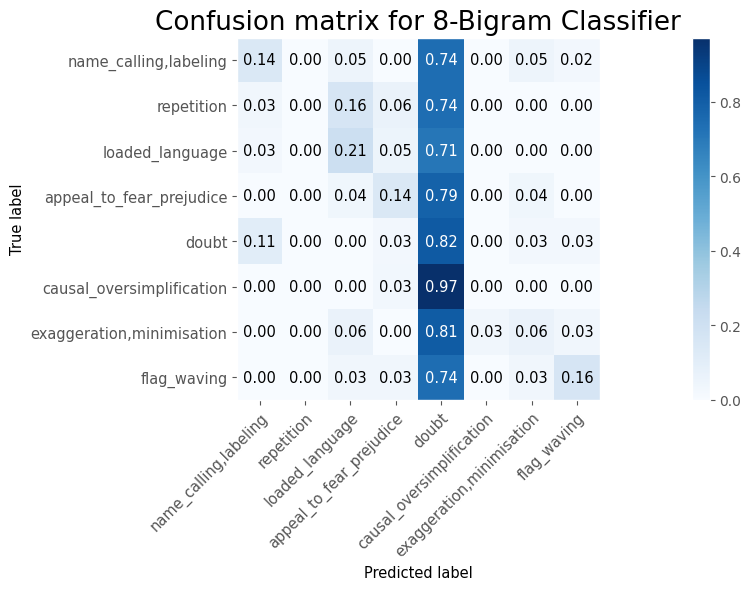

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


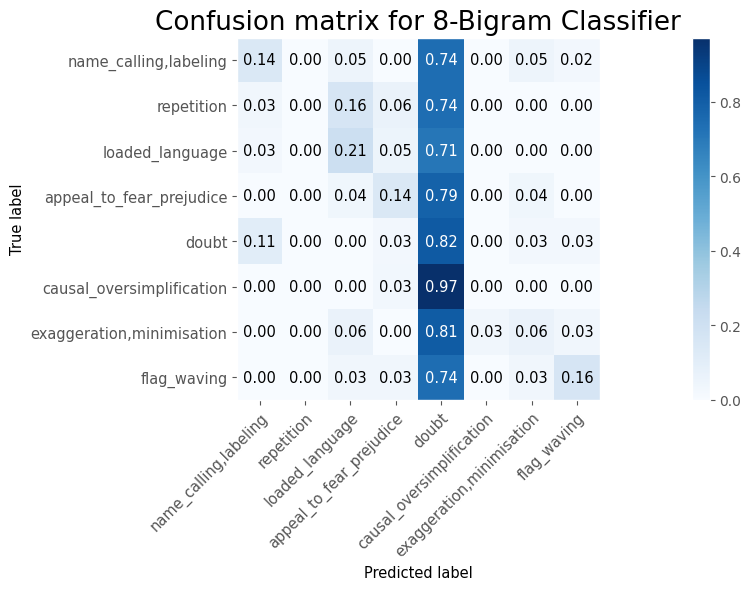

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


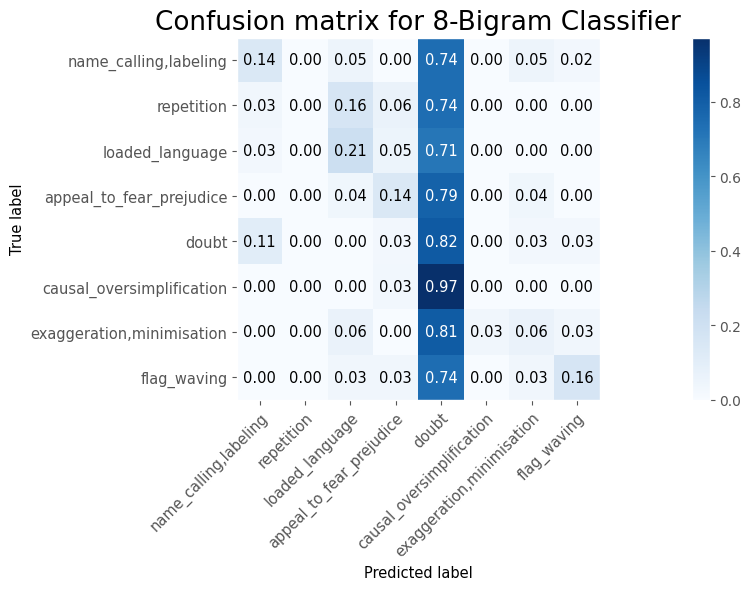

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


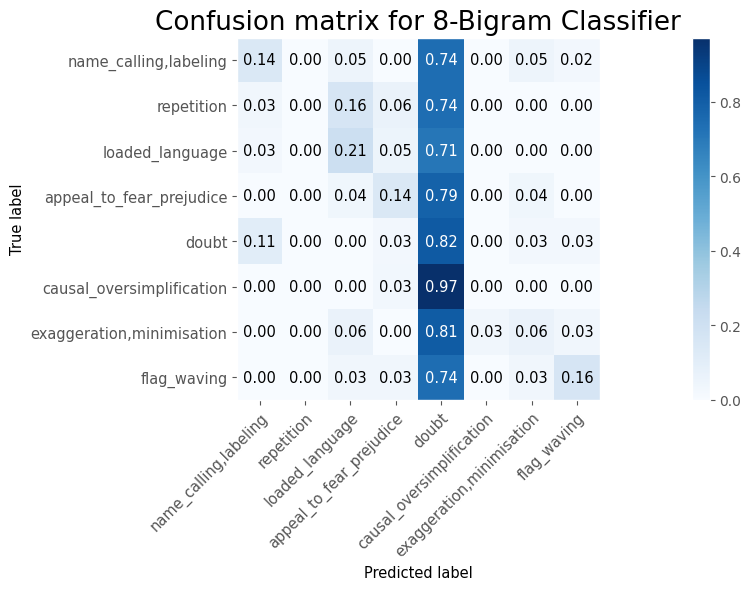

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


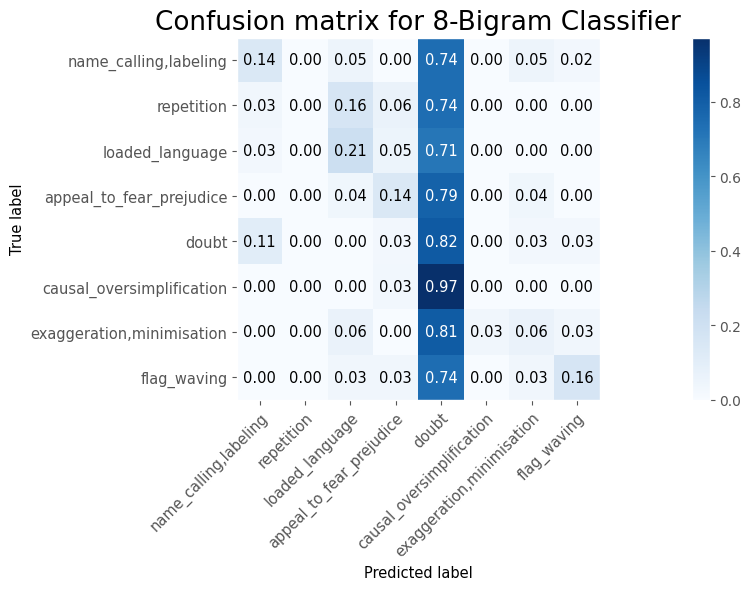

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


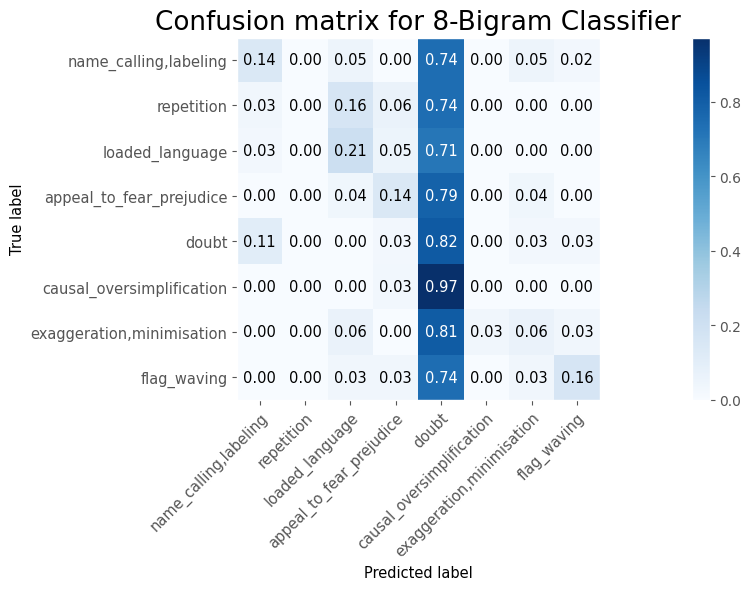

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


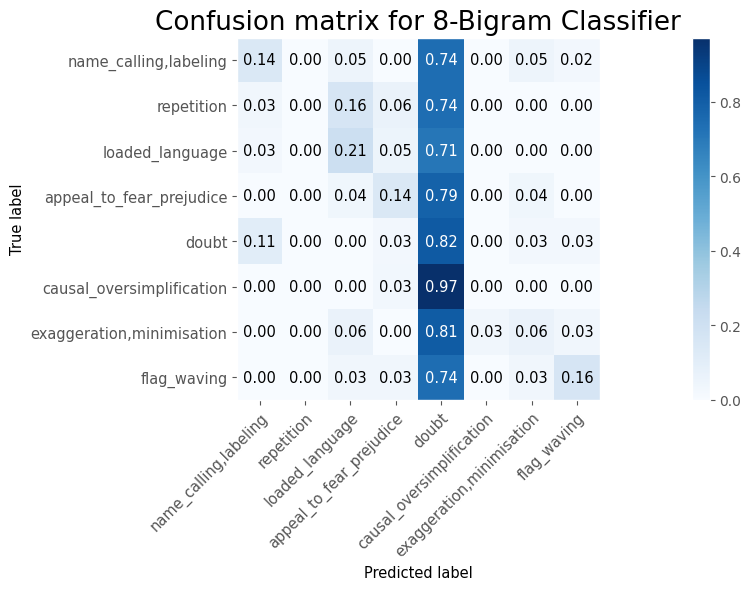

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


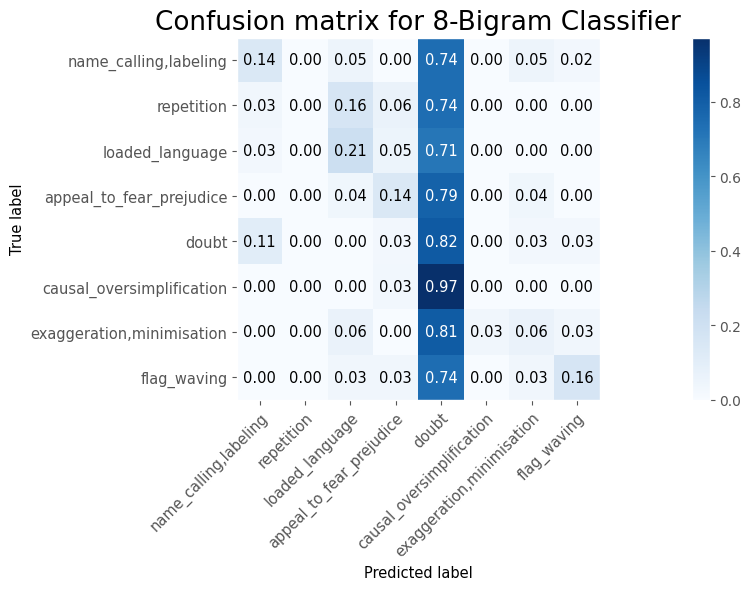

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


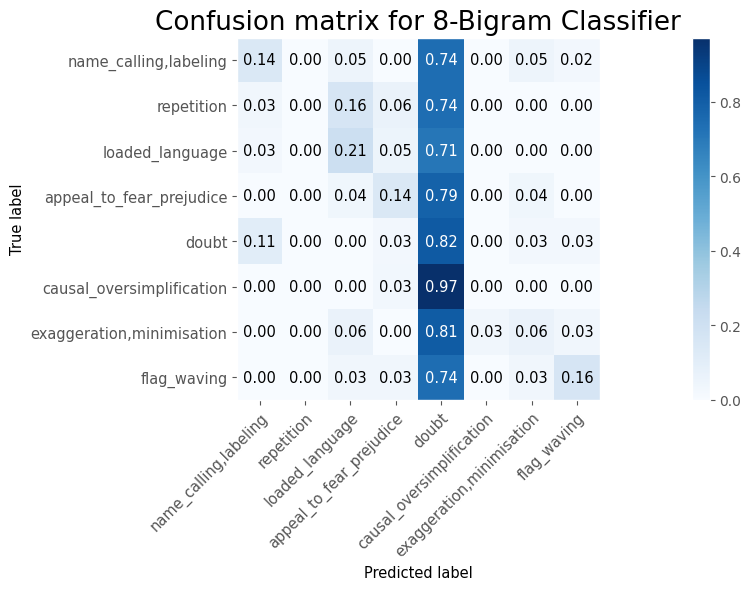

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


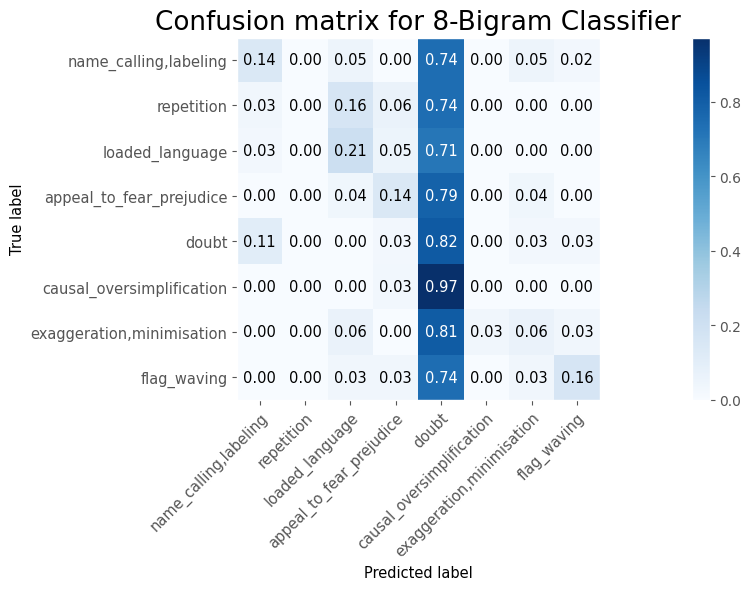

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Highest default value is: 1e-10 with F1-score: 0.16336629102346897


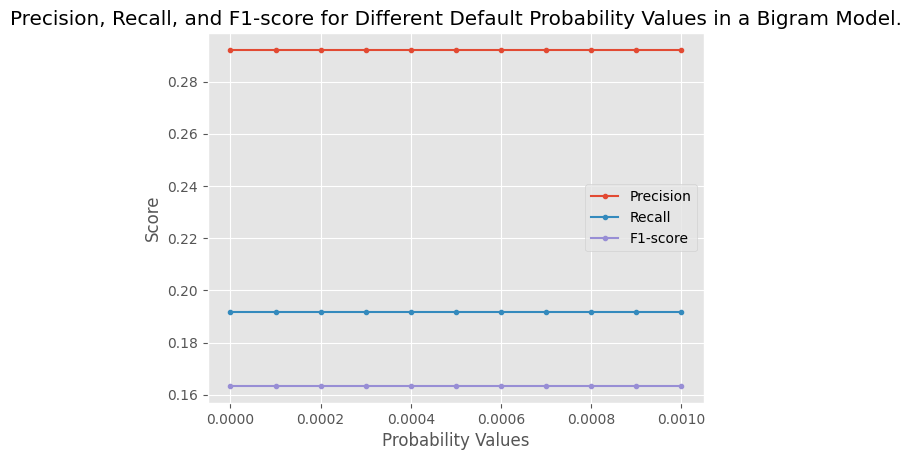

In [ ]:
# track scores
experiment_scores = {}

# default values to test
default_values = [0.0000000001, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]

# test each default value
for default_value in default_values:
  models_array = [BigramModel(propaganda_class, default_value) for propaganda_class in df_class_array]

  # get true labels
  true_labels = df_test['label']

  # init prediciton list
  predicted_labels = []

  # classify all test sentences
  for test_sentence in df_test['preprocessed']:
    predicted_labels.append(classify(test_sentence, models_array))

  #plot a confusion matrix of the results
  plot_confusion_matrix(y_true=true_labels, y_pred=predicted_labels, normalize=True, title="Confusion matrix for 8-Bigram Classifier", magnify=0.1)

  #collect metrics
  precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels)
  precision = mean(precision)
  recall = mean(recall)
  f1_score = mean(f1_score)

  # store metrics
  experiment_scores[default_value] = [precision, recall, f1_score]


#extract precision, recall, and F1-score values
probabilities = list(experiment_scores.keys())
precision_values = [metrics[0] for metrics in experiment_scores.values()]
recall_values = [metrics[1] for metrics in experiment_scores.values()]
f1_score_values = [metrics[2] for metrics in experiment_scores.values()]

# get best performing default value and its F1 score.
max_index = f1_score_values.index(max(f1_score_values))
print(f"Highest default value is: {default_values[max_index]} with F1-score: {max(f1_score_values)}" )

#plot precision, recall, and F1-score
plt.plot(probabilities, precision_values, marker='.', label='Precision')
plt.plot(probabilities, recall_values, marker='.', label='Recall')
plt.plot(probabilities, f1_score_values, marker='.', label='F1-score')

#add labels and legend
plt.xlabel('Probability Values')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score for Different Default Probability Values in a Bigram Model.')
plt.legend()

# show plot
plt.grid(True)
plt.show()


bigram_f1_scores = f1_score_values

In [ ]:
# see unseen bigram rate for each class.

models_array = [BigramModel(propaganda_class, 123) for propaganda_class in df_class_array]
percentages = []
for j, model in enumerate(models_array):
  num_of_unseen_prop = 0

  word_count = 0
  for sentence in df_test['preprocessed']:
    sentence = ["START"] + sentence + ["<END>"]
    for i in range(len(sentence)-1):
      word1 = sentence[i]
      word2 = sentence[i+1]
      word_count += 1
      if model.get_bigram_probability(word1, word2) == 123:
        num_of_unseen_prop += 1

  percentage = (num_of_unseen_prop/word_count)*100
  percentages.append(percentage)

  print(f"Percentage of unseen bigrams in {index_to_technique[j]} test set: {percentage}%")

Percentage of unseen bigrams in flag_waving test set: 95.68648079957917%
Percentage of unseen bigrams in loaded_language test set: 98.68490268279852%
Percentage of unseen bigrams in doubt test set: 95.528669121515%
Percentage of unseen bigrams in name_calling,labeling test set: 97.47501315097317%
Percentage of unseen bigrams in appeal_to_fear_prejudice test set: 94.3713834823777%
Percentage of unseen bigrams in repetition test set: 97.0541820094687%
Percentage of unseen bigrams in causal_simplification test set: 100.0%
Percentage of unseen bigrams in exaggeration,minimisation test set: 95.94950026301946%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# get F1 scores for report table.
print(unigram_f1_scores)
print(bigram_f1_scores)

[0.35179457111711443, 0.368036938370047, 0.36374974119375114, 0.3578278318826379, 0.3455565243833022, 0.3448136843728582, 0.34906963531162416, 0.3351854644790171, 0.3316390529995936, 0.3131750287764912, 0.31299099843056044]
[0.16336629102346897, 0.16336629102346897, 0.16336629102346897, 0.16336629102346897, 0.16336629102346897, 0.16336629102346897, 0.16336629102346897, 0.16336629102346897, 0.16336629102346897, 0.16336629102346897, 0.16336629102346897]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
